# Importing all the necessry libraries

In [1]:
from tensorflow.keras.applications import VGG16, VGG19, Xception, InceptionV3, ResNet50
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from numpy import load
import pickle
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dropout, Dense, Flatten, MaxPooling2D, Convolution2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Create a Model

In [2]:
# create a model
def create_model(pretrained_model_name, last_layer, input_shape = (150, 150, 3), weights = 'imagenet', isTrainable = False, dropout_rate = 0.5, activation = 'relu'):
  pretrained_model = pretrained_model_name(input_shape = input_shape, include_top = False, weights = weights)
  
  for layer in pretrained_model.layers:
      layer.trainable = isTrainable

  last_layer = pretrained_model.get_layer(last_layer)
  last_output = last_layer.output


  x = layers.Flatten()(last_output)
  x = layers.Dense(1024, activation = activation)(x)
  x = layers.Dropout(dropout_rate)(x)
  x = layers.Dense(6, activation='softmax')(x)           

  model = Model(pretrained_model.input, x)
  # model.summary()
  return model

# Compile a model

In [3]:
def compile_model(model_name, optimizer = 'SGD', loss_function = 'sparse_categorical_crossentropy', learning_rate = 0.0001):
  model_name.compile(optimizer = SGD(lr = learning_rate), loss = loss_function, metrics = ['acc'])

# Train a model

In [4]:
def fit_model(model, X_train, y_train, X_val, y_val, epochs = 100, batch_size = 32, callbacks = None):
  model.fit(X_train, y_train , epochs = epochs, validation_data = (X_val, y_val), callbacks = callbacks, batch_size = batch_size)

# Functions to save & load model and its history

In [5]:
#saving model and its history
def save_model_and_history(model, path_file_name_model, path_file_name_history):
  model.save(path_file_name_model)
  with open(path_file_name_history, 'wb') as f:
        pickle.dump(model.history.history, f)

#loading model and its history
def load_model_and_history(path_file_name_model, path_file_name_history):
  my_model = load_model(path_file_name_model)
  my_history = load(path_file_name_history, allow_pickle=True)
  return my_model, my_history

# Evaluate a model

In [6]:
# evaluation of a model
def evaluate_a_model(model, X_test, y_test):
  evaluation = model.evaluate(X_test, y_test)
  return evaluation

# Confusion matrix & Classification report

In [7]:
def create_and_draw_confusion_matrix_classification_report(model, X_test, y_test):
  # confusion matrix
  predProbabilities = model.predict(X_test)
  predictions = np.argmax(predProbabilities, axis=1)
  cm = confusion_matrix(y_test, predictions, normalize = 'true')
  # plotting confusion matrix heatmap
  x_labels = ['building', 'forest', 'glacier', 'mountain', 'sea', 'street']
  y_labels = ['building', 'forest', 'glacier', 'mountain', 'sea', 'street']
  f = sns.heatmap(cm, annot = True, xticklabels = x_labels, yticklabels = y_labels)
  # classification report
  cr = classification_report(y_test, predictions, labels=None, target_names=None)
  print(cr)
  return cm, cr

# Plot accuracy and loss graph

In [8]:
def plot_accuracy_and_loss_graphs(history):
  # accuracy
  plt.plot(history['acc'])
  plt.plot(history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # loss
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

# Function to get label names from prediction

In [9]:
# function for label names
def getLabels(prediction):
  labels = {'Building':0 ,'Forest':1,'Glacier':2,'Mountain':3,'Sea':4,'Street':5} 
  for x , y in labels.items() :
    if prediction == y :
      return x

# Predictions array for test set

In [10]:
def predict_test_set(X_test, model):
  predProbabilities = model.predict(X_test)
  predictions = np.argmax(predProbabilities, axis=1)
  return predictions



# Novel CNN

In [11]:
def create_novel_CNN():
  model = Sequential()

  model.add(Convolution2D(filters = 512, kernel_size = (3, 3), input_shape = (150, 150, 3), activation ='relu'))
  model.add(Convolution2D(256, 3, activation ='relu'))
  model.add(Convolution2D(128, 3, activation ='relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))

  model.add(Convolution2D(filters = 64, kernel_size = (3, 3), activation ='relu'))
  model.add(Convolution2D(64, 3, activation ='relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
                                                              
  model.add(Convolution2D(filters = 32, kernel_size = (3, 3), activation ='relu'))
  model.add(Convolution2D(16, 3, activation ='relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))

  model.add(Flatten())
  model.add(Dense(units = 1024, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units = 512, activation = 'relu'))
  model.add(Dropout(0.4))
  model.add(Dense(units = 256, activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(Dense(units = 6, activation = 'softmax'))
  model.summary()
  return model

# Augmentetd data files

In [12]:
def create_data_augmented_files(train_direct_path, test_direct_path, horizontal_flip = True, width_shift_range=0.3, height_shift_range=0.3, zoom_range=[0.5,1.0], validation_split = 0.15, batch_size = 64):
  dataGen = ImageDataGenerator(rescale = 1./255, horizontal_flip=horizontal_flip,  width_shift_range=0.3, height_shift_range=0.3, zoom_range=[0.5,1.0], validation_split = 0.15)

  train_aug = dataGen.flow_from_directory(train_direct_path, target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size = batch_size, subset='training')
  validate_aug = dataGen.flow_from_directory(train_direct_path, target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size = batch_size, subset='validation')

  datagen = ImageDataGenerator(1./255)
  test_aug = datagen.flow_from_directory(test_direct_path, target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size = batch_size)
  return train_aug, validate_aug, test_aug

# Fit method for augmented data

In [13]:
def fit_model_with_augmented_data(model, train_aug, val_aug, callbacks = None, epochs = 50):
  model.fit_generator(train_aug , epochs = epochs, validation_data = (val_aug), callbacks = callbacks)

# K-fold cross validation

In [14]:
def kFold_validation(pretrained_model_name, last_layer, X_train, y_train, n_splits = 5, epochs = 50):
  seed = 7
  np.random.seed(seed)
  kfold = StratifiedKFold(n_splits= n_splits, shuffle=True, random_state=seed)

  cvscores = []
  for train, test in kfold.split(X_train, y_train):
    model = create_model(pretrained_model_name, last_layer)
    compile_model(model)
    model.fit(X_train[train], y_train[train], epochs = epochs)
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
  return cvscores

# Grid search

In [15]:
def grid_search(pretrained_model_name, last_layer, X_train, y_train, cv = 5, batch_size = [20, 32, 64], optimizer = ['SGD', 'RMSprop', 'Adam'], learn_rate= [0.001, 0.0001, 0.00001], epochs = [20, 30, 40]):
  # fix random seed for reproducibility
  seed = 7
  np.random.seed(seed)
  # define the grid search parameters
  param_grid = dict(batch_size=batch_size, optimizer=optimizer, epochs = epochs, learn_rate=learn_rate)
  model = KerasClassifier(build_fn=create_model(pretrained_model_name, last_layer), verbose = 0)
  grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv)
  grid_result = grid.fit(X_train, y_train, epochs = 1)
  # summarize results
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))

# Practical example of training the model by using all these function

In [16]:
# mounting google Colab with my Google drive to get the data set
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Importing data files from Google drive

In [17]:
# train images
trainXdata = load('/content/gdrive/My Drive/DataFiles/Splitted_Cleaned/X_train.npz')
X_train = trainXdata['arr_0']
trainYdata = load('/content/gdrive/My Drive/DataFiles/Splitted_Cleaned/y_train.npz')
y_train = trainYdata['arr_0']

# test images
testXdata = load('/content/gdrive/My Drive/DataFiles/Splitted_Cleaned/X_test.npz')
X_test = testXdata['arr_0']
testYdata = load('/content/gdrive/My Drive/DataFiles/Splitted_Cleaned/y_test.npz')
y_test = testYdata['arr_0']

# validation images
validateXdata = load('/content/gdrive/My Drive/DataFiles/Splitted_Cleaned/X_val.npz')
X_val = validateXdata['arr_0']
validateYdata = load('/content/gdrive/My Drive/DataFiles/Splitted_Cleaned/y_val.npz')
y_val = validateYdata['arr_0']

### chcking the shape of all train, validation and test set

In [18]:

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(11694, 150, 150, 3)
(11694,)
(2067, 150, 150, 3)
(2067,)
(2977, 150, 150, 3)
(2977,)


### Create and compile the model

In [19]:
my_model = create_model(InceptionV3, 'mixed7' , (150, 150, 3))
compile_model(my_model)

### train the model

In [20]:
fit_model(my_model, X_train, y_train, X_val, y_val, epochs = 150,  batch_size = 64)

Epoch 1/150
183/183 [==============================] - 7s 36ms/step - loss: 1.6500 - acc: 0.3151 - val_loss: 1.3580 - val_acc: 0.6168
Epoch 2/150
183/183 [==============================] - 5s 29ms/step - loss: 1.2918 - acc: 0.5520 - val_loss: 1.0948 - val_acc: 0.7421
Epoch 3/150
183/183 [==============================] - 5s 29ms/step - loss: 1.0704 - acc: 0.6638 - val_loss: 0.9236 - val_acc: 0.7857
Epoch 4/150
183/183 [==============================] - 5s 28ms/step - loss: 0.9307 - acc: 0.7218 - val_loss: 0.8047 - val_acc: 0.8113
Epoch 5/150
183/183 [==============================] - 5s 28ms/step - loss: 0.8263 - acc: 0.7531 - val_loss: 0.7187 - val_acc: 0.8316
Epoch 6/150
183/183 [==============================] - 5s 28ms/step - loss: 0.7504 - acc: 0.7781 - val_loss: 0.6539 - val_acc: 0.8462
Epoch 7/150
183/183 [==============================] - 5s 28ms/step - loss: 0.6948 - acc: 0.7938 - val_loss: 0.6033 - val_acc: 0.8573
Epoch 8/150
183/183 [==============================] - 5s 28ms

### saving the model and then reloading it again

In [21]:
save_model_and_history(my_model, '/content/gdrive/My Drive/DataFiles/Models/Inception_best_model.h5', '/content/gdrive/My Drive/DataFiles/History/Inception_best_model')
Inception_best = load_model_and_history('/content/gdrive/My Drive/DataFiles/Models/Inception_best_model.h5', '/content/gdrive/My Drive/DataFiles/History/Inception_best_model')
Inception_best_model = Inception_best[0]
Inception_best_model_history = Inception_best[1]

### creating classification report and plotting confusion matrix on test data

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       435
           1       0.98      0.98      0.98       474
           2       0.87      0.85      0.86       537
           3       0.85      0.85      0.85       525
           4       0.92      0.94      0.93       505
           5       0.93      0.94      0.93       501

    accuracy                           0.91      2977
   macro avg       0.91      0.91      0.91      2977
weighted avg       0.91      0.91      0.91      2977



(array([[0.92413793, 0.        , 0.        , 0.00229885, 0.0091954 ,
         0.06436782],
        [0.        , 0.98312236, 0.        , 0.00632911, 0.00632911,
         0.00421941],
        [0.00372439, 0.00558659, 0.84543762, 0.11173184, 0.03165736,
         0.0018622 ],
        [0.00190476, 0.00190476, 0.12      , 0.84952381, 0.02285714,
         0.00380952],
        [0.01188119, 0.00594059, 0.01188119, 0.02376238, 0.94059406,
         0.00594059],
        [0.04590818, 0.00598802, 0.        , 0.00399202, 0.00598802,
         0.93812375]]),
 '              precision    recall  f1-score   support\n\n           0       0.93      0.92      0.93       435\n           1       0.98      0.98      0.98       474\n           2       0.87      0.85      0.86       537\n           3       0.85      0.85      0.85       525\n           4       0.92      0.94      0.93       505\n           5       0.93      0.94      0.93       501\n\n    accuracy                           0.91      2977\n   mac

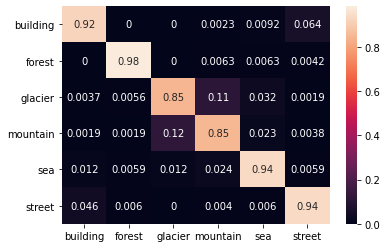

In [22]:
create_and_draw_confusion_matrix_classification_report(Inception_best_model, X_test, y_test)

### Plotting accuracy and loss graphs

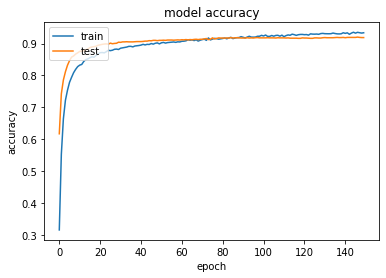

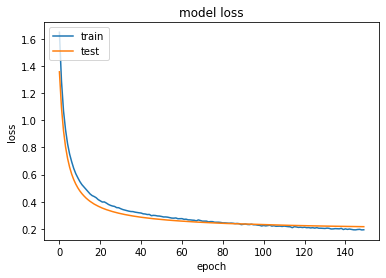

In [23]:
plot_accuracy_and_loss_graphs(Inception_best_model_history)

### Getting the predictions array for test set

In [24]:
prediction_array = predict_test_set(X_test, Inception_best_model)

### Selecting a random image from test set and getting its prediction

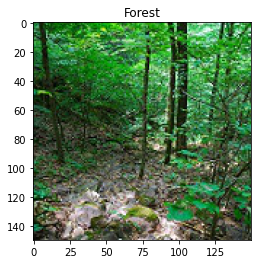

In [26]:
i = 500
plt.title(getLabels(prediction_array[i]))
plt.imshow(X_test[i])
